In [1]:
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from scipy.stats import norm
import numpy as np
from tqdm import tqdm
import sys
sys.path.append('../src')
from models import open_pickle, filter_terms_not_in_wemodel

In [2]:
we_model_name = "sg_dim300_min100_win5"
we_vector_size = 300
we_model_dir = '../data/external/wiki-english/wiki-english-20171001/%s' % we_model_name

we_model = Word2Vec.load(we_model_dir+'/model.gensim')
print ('loading done!')

loading done!


In [3]:
RESULTS_FILEPATH = '../data/interim/association_metric_exps.pickle'
EXPERIMENT_DEFINITION_FILEPATH = '../data/interim/experiment_definitions.pickle'
SIGTEST_IMAGE_FILEPATH = '../reports/figures/sigtest_intervals.png'
SIGTEST_HORIZONTAL_IMAGE_FILEPATH = '../reports/figures/sigtest_intervals_horizontal.png'

exp_def_dict = open_pickle(EXPERIMENT_DEFINITION_FILEPATH)
results_dict = open_pickle(RESULTS_FILEPATH)

In [16]:
results_dict[1]

defaultdict(dict,
            {'first': {'X_array': array([ 0.08113076,  0.18911934, -0.0954811 ,  0.13401467,  0.09897012,
                      0.19287561,  0.11558053,  0.06996465,  0.12096066,  0.12797187,
                      0.11942707,  0.18256408,  0.17806363,  0.17999095,  0.11687332,
                      0.08817419,  0.13236946,  0.10520089,  0.17782208,  0.09271343,
                      0.14632878,  0.13019669,  0.14671066,  0.15014505], dtype=float32),
              'Y_array': array([-0.04801004, -0.06460989, -0.08932857, -0.06297787, -0.40200305,
                     -0.1162259 ,  0.05139589, -0.29557508, -0.14763156,  0.11352445,
                     -0.1613886 , -0.0787251 , -0.19676779, -0.14766207, -0.03967397,
                      0.07359396, -0.04168847,  0.08253389, -0.0736915 , -0.06181172,
                      0.0839064 ,  0.08104831,  0.03454182, -0.13286161], dtype=float32),
              'X_mean': 0.12423697,
              'Y_mean': -0.068337,
            

In [4]:
def get_error(dist, interval_size):
    '''Interval size should be 0<x<1'''
    loc = np.mean(dist)
    scale = np.std(dist, ddof=1)
    err = loc - norm.ppf((1-interval_size)/2, loc=loc, scale=scale)
    return err

In [5]:
def get_p_value(dist, test_statistic):
    loc = np.mean(dist)
    scale = np.std(dist, ddof=1)
    return norm.cdf(test_statistic, loc=loc, scale=scale)

In [6]:
def add_axes_obj_labels(ax, test_num):
    X_AXIS_FONT_SIZE = 12
    Y_AXIS_FONT_SIZE = 15
    test_descriptions = {1: '$s(X_i, Y_i, A, B)$',
                         2: '$s(X, Y_i, A, B)$',
                         3: '$s(X_i, Y, A, B)$'}
    ax.set_xlabel(f'SigTest {test_num}: {test_descriptions[test_num]} \n left=bias towards B, right=bias towards A',
                 fontsize=X_AXIS_FONT_SIZE)
    ax.set_ylabel(f'Experiment Number', fontsize=Y_AXIS_FONT_SIZE)

In [7]:
def annotate_points(ax, txt_array, x_array, y):
    POINT_FONT_SIZE = 10
    NUM_DECIMALS = 3
    for i in range(10):
        ax.annotate(np.round(txt_array[i], NUM_DECIMALS), (x_array[i], y[i]), fontsize=POINT_FONT_SIZE)

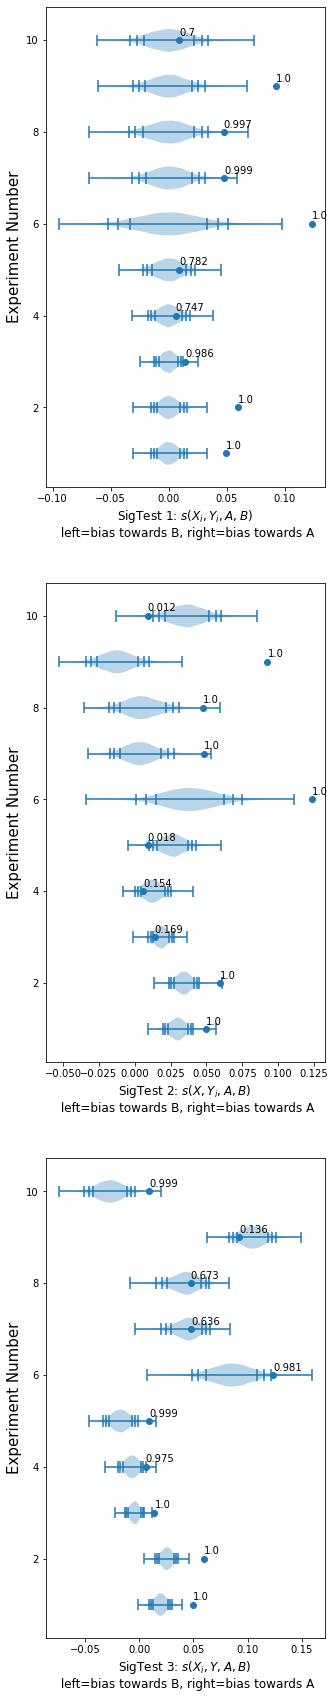

In [17]:
# Violinplot
fig, axs = plt.subplots(3,1, figsize=(5,30))
X_AXIS_LIMITS = [-0.1, 0.35]
Y_ANNOTATION_OFFSET = 0.1
exp_nums = [i for i in range(1,11)]

for test_num in range(1,4):
    ax = axs[test_num - 1]
    test_stats = [results_dict[exp_num]['second']['test_statistic'] for exp_num in exp_nums]
    means = [np.mean(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}']) for exp_num in exp_nums]
    y = [i for i in range(1,11)]
    errors_80 = [get_error(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], 0.8) for exp_num in exp_nums]
    errors_90 = [get_error(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], 0.9) for exp_num in exp_nums]
    errors_95 = [get_error(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], 0.95) for exp_num in exp_nums]
    
    #ax.errorbar(means, y, xerr=errors_80, fmt='|', color='r', capsize=5, label='80% CI')
    #ax.errorbar(means, y, xerr=errors_90, fmt='|', color='g', capsize=5, label='90% CI')
    #ax.errorbar(means, y, xerr=errors_95, fmt='|', color='k', capsize=5, label='95% CI')
    ax.scatter(test_stats, y)
    dists = [results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'] for exp_num in exp_nums]
    quants = [[0.025, 0.05, 0.1, 0.9, 0.95, 0.975] for i in range(10)]
    ax.violinplot(dists, vert=False, quantiles=quants)
    #ax.set_xlim(X_AXIS_LIMITS)
    #fig.suptitle('Sig Tests', fontsize=20)
    #fig.text(0.04, 0.5, 'Experiment Number', va='center', rotation='vertical', fontsize=20)
    p_values = [get_p_value(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], test_stats[exp_num-1]) \
                            for exp_num in exp_nums]
    annotate_points(ax, p_values, test_stats, [c+Y_ANNOTATION_OFFSET for c in y])
    add_axes_obj_labels(ax, test_num)

Means: [-1.2386548e-05, -1.2386548e-05, 1.9979827e-06, -0.00013565653, -1.8445939e-05, -0.00020604176, 7.749893e-05, -4.980314e-06, 4.871774e-06, 0.00011360212]
Means: [0.03004467, 0.03430602, 0.018396096, 0.012489886, 0.026434036, 0.03830569, 0.0039918907, 0.005557055, -0.012162381, 0.036422484]
Means: [0.019468728, 0.025388291, -0.004357319, -0.006692389, -0.01746346, 0.08525587, 0.04404131, 0.041771974, 0.10467476, -0.027207311]


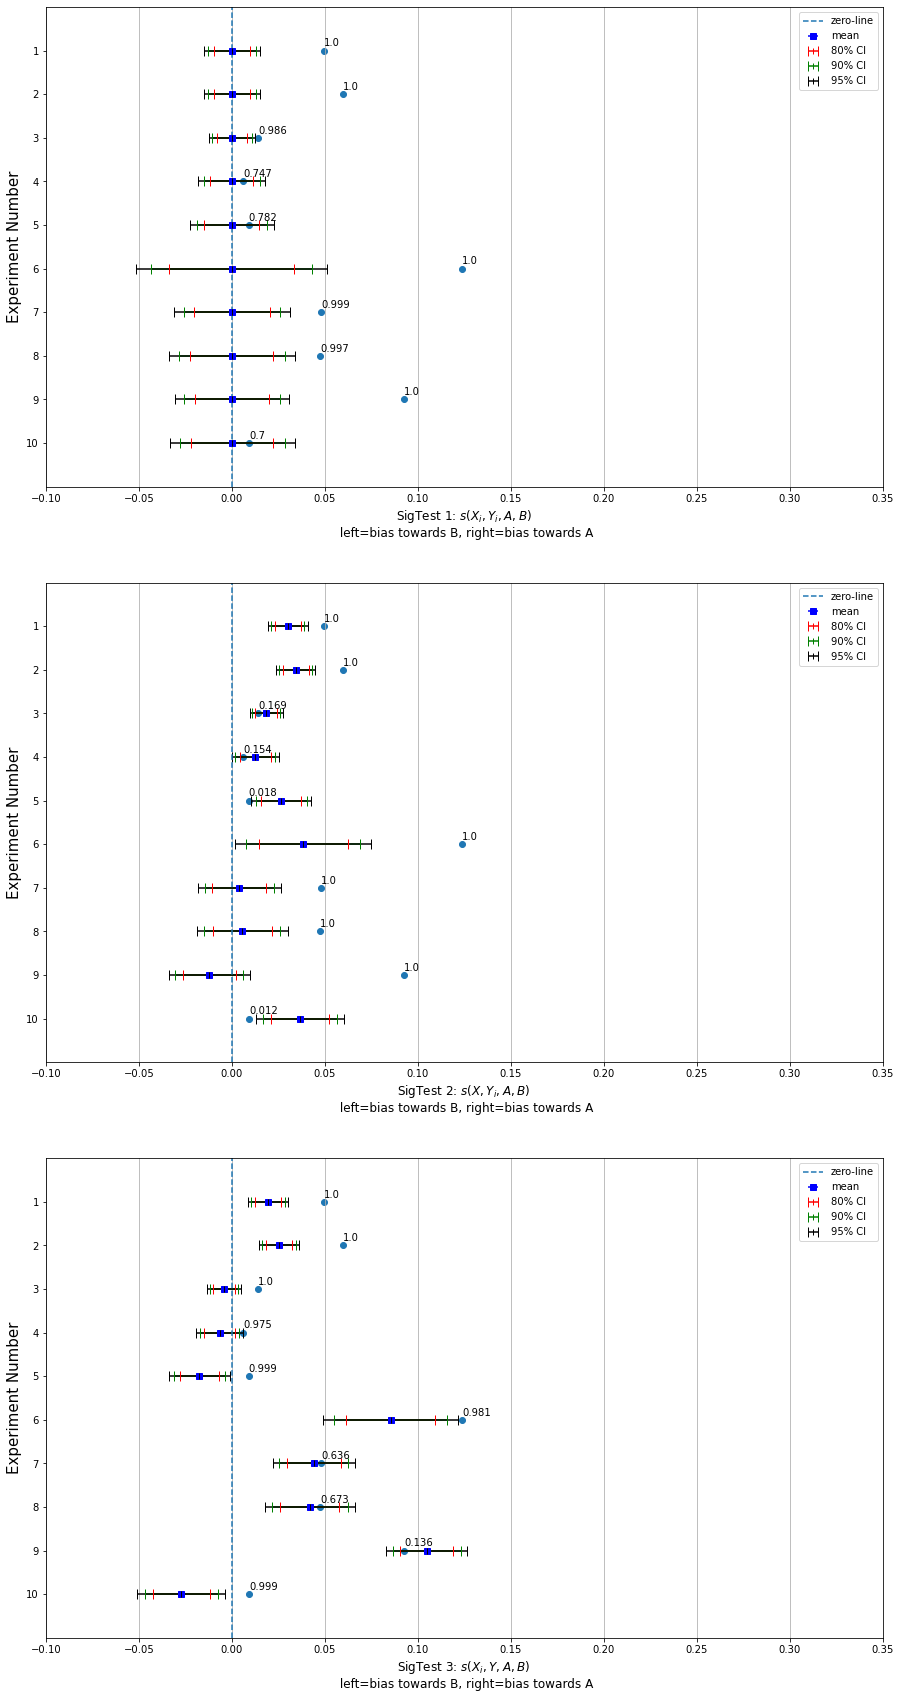

In [29]:
# Whiskers
fig, axs = plt.subplots(3,1, figsize=(15,30))
X_AXIS_LIMITS = [-0.1, 0.35]
Y_AXIS_LIMITS = [11,0]
Y_ANNOTATION_OFFSET = -0.1
exp_nums = [i for i in range(1,11)]

for test_num in range(1,4):
    ax = axs[test_num - 1]
    test_stats = [results_dict[exp_num]['second']['test_statistic'] for exp_num in exp_nums]
    means = [np.mean(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}']) for exp_num in exp_nums]
    print(f'Means: {means}')
    y = [i for i in range(1,11)]
    errors_80 = [get_error(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], 0.8) for exp_num in exp_nums]
    errors_90 = [get_error(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], 0.9) for exp_num in exp_nums]
    errors_95 = [get_error(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], 0.95) for exp_num in exp_nums]
    
    ax.errorbar(means, y, xerr=0, fmt='s', color='b', label='mean')
    ax.errorbar(means, y, xerr=errors_80, fmt='|', color='r', capsize=5, label='80% CI')
    ax.errorbar(means, y, xerr=errors_90, fmt='|', color='g', capsize=5, label='90% CI')
    ax.errorbar(means, y, xerr=errors_95, fmt='|', color='k', capsize=5, label='95% CI')
    ax.scatter(test_stats, y)
    dists = [results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'] for exp_num in exp_nums]
    ax.axvline(0, label='zero-line', linestyle='--')
    ax.xaxis.grid()
    #fig.suptitle('Sig Tests', fontsize=20)
    #fig.text(0.04, 0.5, 'Experiment Number', va='center', rotation='vertical', fontsize=20)
    p_values = [get_p_value(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], test_stats[exp_num-1]) \
                            for exp_num in exp_nums]
    annotate_points(ax, p_values, test_stats, [c+Y_ANNOTATION_OFFSET for c in y])
    add_axes_obj_labels(ax, test_num)
    
    ax.set_xlim(X_AXIS_LIMITS)
    ax.set_ylim(Y_AXIS_LIMITS)
    ax.set_yticks(y)
    ax.legend()
plt.savefig(SIGTEST_IMAGE_FILEPATH)

[0.049525782, 0.059706695, 0.01403678, 0.0059331534, 0.008989021, 0.12376761, 0.0479557, 0.047334008, 0.0925075, 0.009101566]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0.049525782, 0.059706695, 0.01403678, 0.0059331534, 0.008989021, 0.12376761, 0.0479557, 0.047334008, 0.0925075, 0.009101566]
[0.049525782, 0.059706695, 0.01403678, 0.0059331534, 0.008989021, 0.12376761, 0.0479557, 0.047334008, 0.0925075, 0.009101566]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0.049525782, 0.059706695, 0.01403678, 0.0059331534, 0.008989021, 0.12376761, 0.0479557, 0.047334008, 0.0925075, 0.009101566]
[0.049525782, 0.059706695, 0.01403678, 0.0059331534, 0.008989021, 0.12376761, 0.0479557, 0.047334008, 0.0925075, 0.009101566]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0.049525782, 0.059706695, 0.01403678, 0.0059331534, 0.008989021, 0.12376761, 0.0479557, 0.047334008, 0.0925075, 0.009101566]


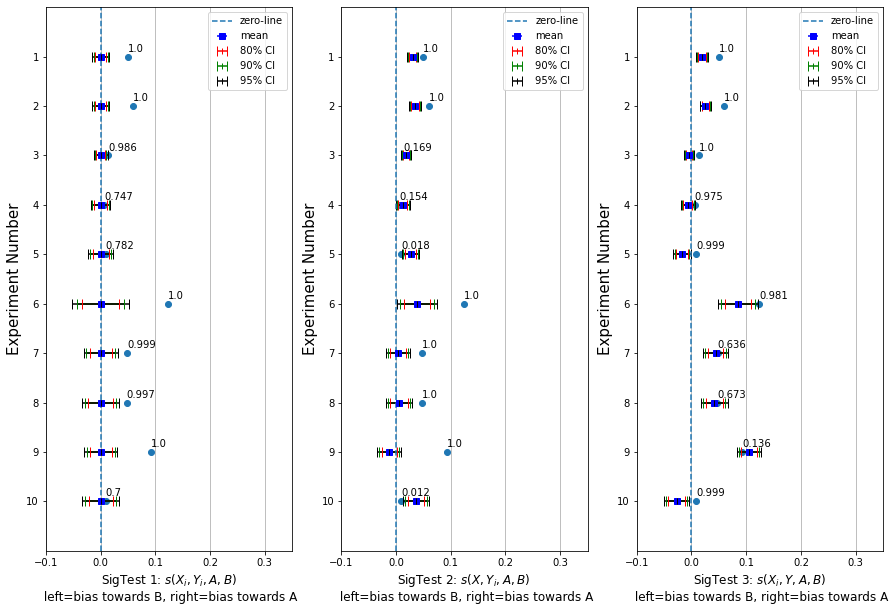

In [26]:
# Whiskers
fig, axs = plt.subplots(1,3, figsize=(15, 10))
X_AXIS_LIMITS = [-0.1, 0.35]
Y_AXIS_LIMITS = [11,0]
Y_ANNOTATION_OFFSET = -0.1
exp_nums = [i for i in range(1,11)]

for test_num in range(1,4):
    ax = axs[test_num - 1]
    test_stats = [results_dict[exp_num]['second']['test_statistic'] for exp_num in exp_nums]
    print(test_stats)
    means = [np.mean(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}']) for exp_num in exp_nums]
    y = [i for i in range(1,11)]
    print(y)
    errors_80 = [get_error(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], 0.8) for exp_num in exp_nums]
    errors_90 = [get_error(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], 0.9) for exp_num in exp_nums]
    errors_95 = [get_error(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], 0.95) for exp_num in exp_nums]
    
    ax.errorbar(means, y, xerr=0, fmt='s', color='b', label='mean')
    ax.errorbar(means, y, xerr=errors_80, fmt='|', color='r', capsize=5, label='80% CI')
    ax.errorbar(means, y, xerr=errors_90, fmt='|', color='g', capsize=5, label='90% CI')
    ax.errorbar(means, y, xerr=errors_95, fmt='|', color='k', capsize=5, label='95% CI')
    ax.scatter(test_stats, y)
    print(test_stats)
    ax.xaxis.grid()
    dists = [results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'] for exp_num in exp_nums]
    ax.axvline(0, label='zero-line', linestyle='--')
    #fig.suptitle('Sig Tests', fontsize=20)
    #fig.text(0.04, 0.5, 'Experiment Number', va='center', rotation='vertical', fontsize=20)
    p_values = [get_p_value(results_dict[exp_num]['second'][f'sigtest_dist_{test_num}'], test_stats[exp_num-1]) \
                            for exp_num in exp_nums]
    annotate_points(ax, p_values, test_stats, [c+Y_ANNOTATION_OFFSET for c in y])
    add_axes_obj_labels(ax, test_num)
    
    ax.set_xlim(X_AXIS_LIMITS)
    ax.set_yticks(y)
    ax.set_ylim(Y_AXIS_LIMITS)
    ax.legend()
plt.savefig(SIGTEST_HORIZONTAL_IMAGE_FILEPATH)

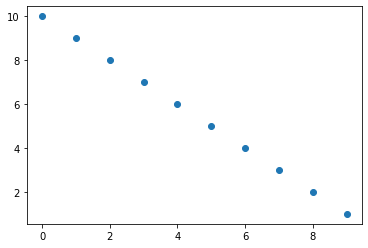

In [18]:
x = [i for i in range(10)]
y = [10-i for i in range(10)]
plt.scatter(x,y)